# Base forecaster against open questions -- test community forecast alignment

## Imports

In [25]:
from forecasting_tools import MetaculusApi, ApiFilter
from datetime import datetime, timedelta
import asyncio

In [2]:
from load_secrets import load_secrets
load_secrets()

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

## Question sample

In [89]:
num_of_questions_to_return = 42

In [90]:
one_year_from_now = datetime.now() + timedelta(days=365)
api_filter = ApiFilter(
    allowed_statuses=["open"],
    num_forecasters_gte=40,
    scheduled_resolve_time_lt=one_year_from_now,
    includes_bots_in_aggregates=False,
)

In [91]:
questions = asyncio.run(MetaculusApi.get_questions_matching_filter(
        api_filter,
        num_questions=num_of_questions_to_return,
        randomly_sample=True))

In [92]:
question = questions[0]

In [97]:
[question.api_json['question']['type'] for question in questions]

['binary',
 'binary',
 'binary',
 'binary',
 'multiple_choice',
 'binary',
 'binary',
 'binary',
 'binary',
 'multiple_choice',
 'binary',
 'binary',
 'multiple_choice',
 'binary',
 'binary',
 'binary',
 'multiple_choice',
 'binary',
 'binary',
 'multiple_choice',
 'multiple_choice',
 'multiple_choice',
 'binary',
 'numeric',
 'multiple_choice',
 'multiple_choice',
 'binary',
 'binary',
 'binary',
 'numeric',
 'binary',
 'multiple_choice',
 'binary',
 'binary',
 'binary',
 'binary',
 'binary',
 'multiple_choice',
 'binary',
 'binary',
 'multiple_choice',
 'binary']

## Community forecast and bot forecast apples to apples

### Numeric

In [62]:
def get_denormalized_forecast(question):
    """Get denormalized community forecast from a NumericQuestion object"""
    # Correct path to aggregations (nested under "question" in api_json)
    forecast_values = question.api_json["question"]["aggregations"]["recency_weighted"]["latest"]["forecast_values"]
    
    # Get scaling parameters from the correct location
    range_min = question.api_json["question"]["scaling"]["range_min"]  # 0.0
    range_max = question.api_json["question"]["scaling"]["range_max"]  # 8e12
    
    # Denormalize each value in the 100-point forecast distribution
    return np.array([range_min + x*(range_max - range_min) for x in forecast_values])

In [63]:
pct = get_denormalized_forecast(question)
len(pct)

201

In [75]:
len(np.arange(0,100.5, 0.5))

201

In [64]:
import numpy as np
from scipy.interpolate import PchipInterpolator

def interpolate_forecast(user_data, range_max=8e12):
    """Convert sparse percentile data into full 201-point Metaculus-style forecast."""
    # Add required endpoints based on question scaling
    xp = [0] + list(user_data.keys()) + [100]
    fp = [0] + list(user_data.values()) + [range_max]
    
    # Sort by percentile
    sort_idx = np.argsort(xp)
    xp_sorted = np.array(xp)[sort_idx]
    fp_sorted = np.array(fp)[sort_idx]
    
    # Create monotonic interpolator (preserves curve shape)
    interpolator = PchipInterpolator(xp_sorted, fp_sorted)
    
    # Generate 0-100% in 0.5% increments (201 points)
    return interpolator(np.linspace(0, 100, 201))

In [77]:
import numpy as np
from scipy.interpolate import interp1d

def convert_to_metaculus_format(user_data):
    """Convert user's percentile forecast to Metaculus-style 201-point format using linear interpolation."""
    # Extract and sort user's data points
    xp = sorted(user_data.keys())
    fp = [user_data[p] for p in xp]
    
    # Add extrapolated 0% and 100% using nearest slope
    if 0 not in xp:
        low_slope = (fp[1] - fp[0]) / (xp[1] - xp[0])
        xp = [0] + xp
        fp = [fp[0] - low_slope * xp[1]] + fp
        
    if 100 not in xp:
        high_slope = (fp[-1] - fp[-2]) / (xp[-1] - xp[-2])
        xp = xp + [100]
        fp = fp + [fp[-1] + high_slope * (100 - xp[-2])]
    
    # Create linear interpolator
    interpolator = interp1d(xp, fp, kind='linear', fill_value='extrapolate')
    
    # Generate 201 points (0.0%, 0.5%, 1.0%, ..., 100.0%)
    return interpolator(np.linspace(0, 100, 201))

# Example usage with your data:
user_data = {
    10: 100528394976.04634,
    20: 185306470758.46915,
    40: 795035177598.96,
    60: 3713482050395.8057,
    80: 7226613194431.641,
    90: 7679945044020.596
}

pct_interpolated = convert_to_metaculus_format(user_data)


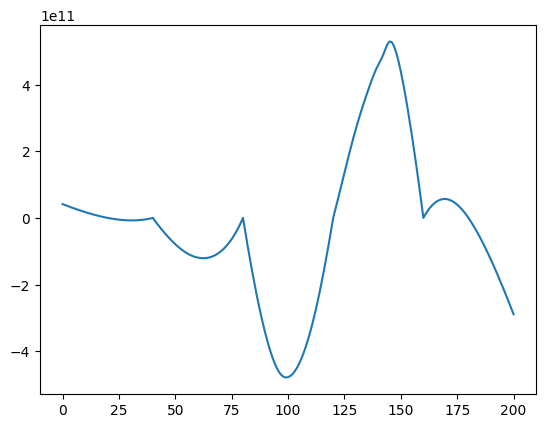

In [80]:
plt.plot(pct-pct_interpolated)

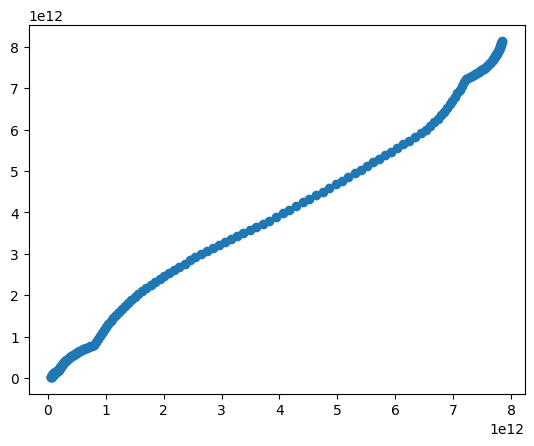

In [81]:
plt.scatter(pct, pct_interpolated)

In [55]:
data = {x: pct[2*x] for x in [10,20,40,60,80,90]}

In [56]:
data

{10: 100528394976.04634,
 20: 185306470758.46915,
 40: 795035177598.96,
 60: 3713482050395.8057,
 80: 7226613194431.641,
 90: 7679945044020.596}

### Binary

### Multiple choice

## Forecast the questions

## Cast the answers to crowd denormalized format

## Assess performance